In [1]:
!pip install mxnet-cu100

#MXNet (From Scratch)

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

mx.random.seed(1)

ctx = mx.gpu()

In [0]:
def transform(data, label):
    return data.reshape((784)).astype('float32')/255.0

train_mnist = gluon.data.vision.FashionMNIST(train = True, transform = transform)
test_mnist = gluon.data.vision.FashionMNIST(train = False, transform = transform)

In [4]:
image = train_mnist[0]
print(image.shape)

(784,)


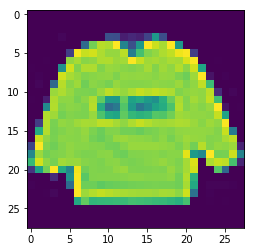

In [5]:
plt.imshow(image.reshape((28, 28)).asnumpy())
plt.show()


##Creating data loader for training and testing

In [0]:
batch_size = 128
training_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
testing_data = gluon.data.DataLoader(test_mnist, batch_size = batch_size, shuffle = False)

##Building the model

In [0]:
weight_scale = .01

# ============================ Defining Encoder =================================
#  Allocate parameters for the first hidden layer of encoder
eW1 = nd.random_normal(shape = (784, 256), scale = weight_scale, ctx = ctx)
eb1 = nd.random_normal(shape = 256, scale = weight_scale, ctx = ctx)

#  Allocate parameters for the ouput layer of encoder
eW2 = nd.random_normal(shape = (256, 128), scale = weight_scale, ctx = ctx)
eb2 = nd.random_normal(shape = 128, scale = weight_scale, ctx = ctx)
# ===============================================================================


# ============================ Defining Decoder =================================
#  Allocate parameters for the first hidden layer of encoder
dW1 = nd.random_normal(shape = (128, 256), scale = weight_scale, ctx = ctx)
db1 = nd.random_normal(shape = 256, scale = weight_scale, ctx = ctx)

#  Allocate parameters for the second hidden layer of encoder
dW2 = nd.random_normal(shape = (256, 784), scale = weight_scale, ctx = ctx)
db2 = nd.random_normal(shape = 784, scale = weight_scale, ctx = ctx)
# ===============================================================================

params = [eW1, eb1, eW2, eb2, dW1, db1, dW2, db2]

sqrs = [] # for adam optimizer
vs = [] # for adam optimizer
for param in params:
    param.attach_grad()
    sqrs.append(param.zeros_like() + 1e-8) # adding 1e-8 for computation stability 
    vs.append(param.zeros_like() + 1e-8) # adding 1e-8 for computation stability 

def encode(inputs):
    layer1 = nd.relu(nd.dot(inputs, eW1) + eb1)
    return nd.relu(nd.dot(layer1, eW2) + eb2)

def decode(encoded):
    layer1 = nd.relu(nd.dot(encoded, dW1) + db1)
    return nd.sigmoid(nd.dot(layer1, dW2) + db2)

##Lets do some sample encoding and decoding

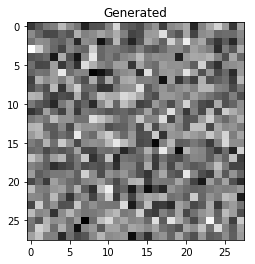

In [8]:
encoded = encode(image.as_in_context(ctx))
decoded = decode(encoded)

plt.imshow(decoded.reshape((28, 28)).asnumpy(), cmap = 'gray')
plt.title('Generated')
plt.show()

##Defining our objective function

In [0]:
def objective(predictions, labels):
    return nd.mean(nd.square(predictions - labels))

##Defining adam parameters optimizer

We will use adam optimizer because sgd performs very slow when a model has many layers, as in our model we have total 5 layers.

In [0]:
def adam(t, params, vs, sqrs, lr = 0.001):
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8

    for param, v, sqr in zip(params, vs, sqrs):
        grad = param.grad / batch_size

        v[:] = beta1 * v + (1. - beta1) * grad
        sqr[:] = beta2 * sqr + (1. - beta2) * nd.square(grad + 1e-8)

        v_bias_corr = v / (1. - beta1 ** t)
        sqr_bias_corr = sqr / (1. - beta2 ** t)

        update = lr * v_bias_corr / (nd.sqrt(sqr_bias_corr + 1e-8) + eps)
        param[:] = param - update

##Initializing rho and defining KL Divergence

In [0]:
rho = nd.full((1, 128), 0.01, ctx = ctx) # shape is (1, 128), becuse 128 is the no of neurons of encoded layer(middel layer of autoencoder).

def kl_divergence(p, q):
#     p = nd.softmax(p)
    q = nd.softmax(q)
    s1 = nd.sum(p * nd.log(p / q))
    s2 = nd.sum((1 - p) * nd.log((1 - p) / (1 - q)))
    return s1 + s2

##Training the  model

Epoch: 0 | Loss: 0.13009


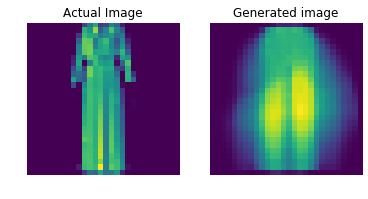

Epoch: 1 | Loss: 0.07870


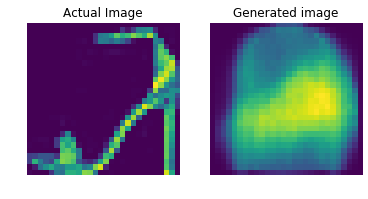

Epoch: 2 | Loss: 0.04377


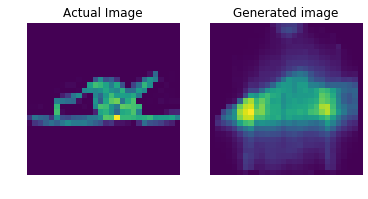

Epoch: 3 | Loss: 0.03629


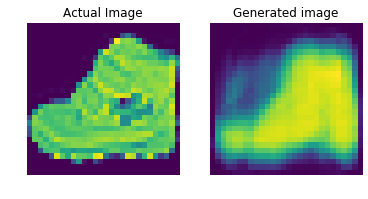

Epoch: 4 | Loss: 0.03251


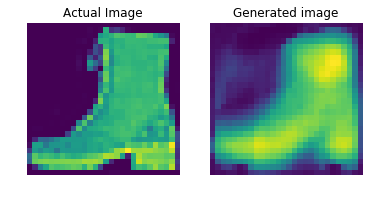

Epoch: 5 | Loss: 0.02805


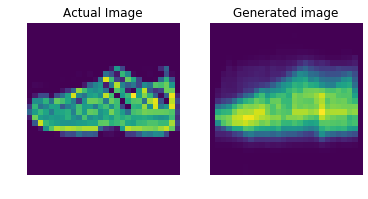

Epoch: 6 | Loss: 0.02512


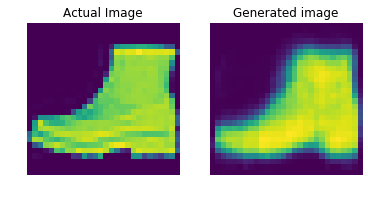

Epoch: 7 | Loss: 0.02378


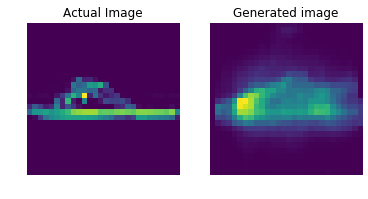

Epoch: 8 | Loss: 0.02288


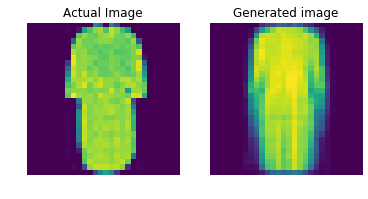

Epoch: 9 | Loss: 0.02207


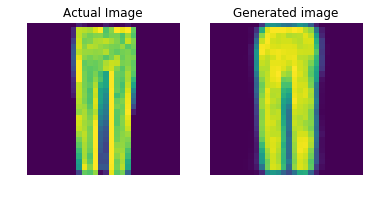

Epoch: 10 | Loss: 0.02114


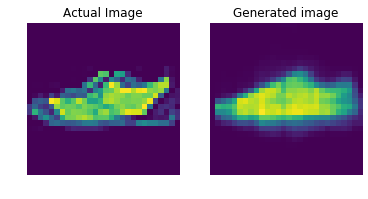

Epoch: 11 | Loss: 0.02045


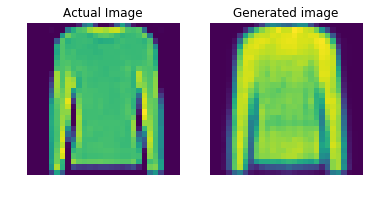

Epoch: 12 | Loss: 0.01987


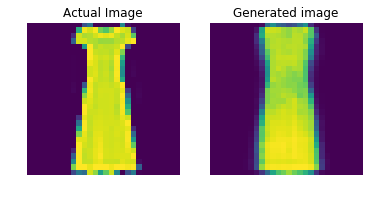

Epoch: 13 | Loss: 0.01919


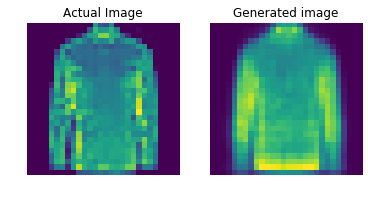

Epoch: 14 | Loss: 0.01866


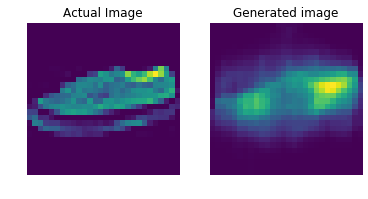

Epoch: 15 | Loss: 0.01803


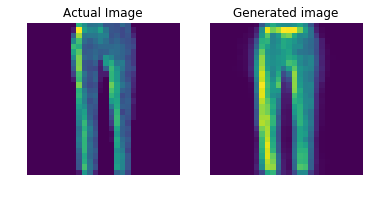

Epoch: 16 | Loss: 0.01758


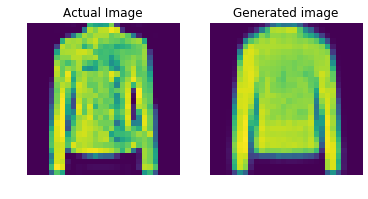

Epoch: 17 | Loss: 0.01718


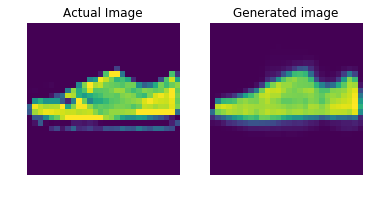

Epoch: 18 | Loss: 0.01688


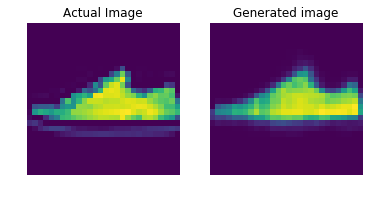

Epoch: 19 | Loss: 0.01658


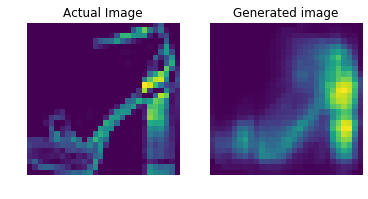

In [12]:
epochs = 20
num_batches = 60000//batch_size
learning_rate = .1
losses = []
t = 0

for epoch in range(epochs):
    cumulative_loss = 0
    for features in training_data:
        t += 1
        features = features.as_in_context(ctx)
        with autograd.record():
            encoded = encode(features)
            decoded = decode(encoded)
            objective_loss = objective(decoded, features)
            
            rho_hat = nd.sum(encoded, axis = 0, keepdims = True) # summing accross batch
            sparsity_loss = 0.1 * kl_divergence(rho, rho_hat)
            
            loss = objective_loss
            
        loss.backward()
        adam(t, params, vs = vs, sqrs = sqrs, lr = learning_rate)
        cumulative_loss += loss
    loss = cumulative_loss.asscalar()/num_batches
    losses.append(loss)
    print(f'Epoch: {epoch} | Loss: {loss:.5f}')
    
    # Below we are generating a sample image from the first image of last batch
    
    encoded = encode(features[0])
    decoded = decode(encoded)
    
    
    plt.subplot(1, 2, 1)
    plt.imshow(features[0].reshape((28, 28)).asnumpy())
    plt.axis('off')
    plt.title('Actual Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(decoded.reshape((28, 28)).asnumpy())
    plt.axis('off')
    plt.title('Generated image')
    
    plt.show()

##Lets generate more images from first 10 images of testing data

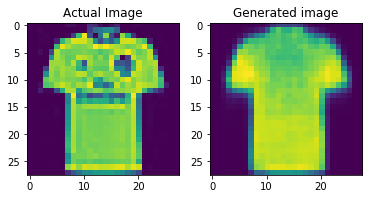

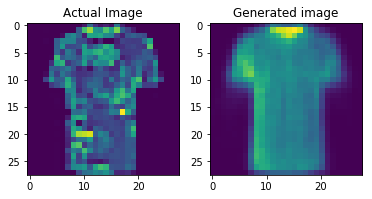

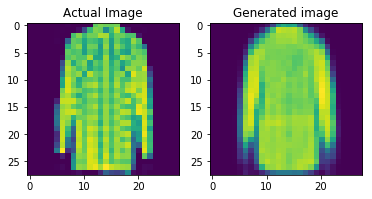

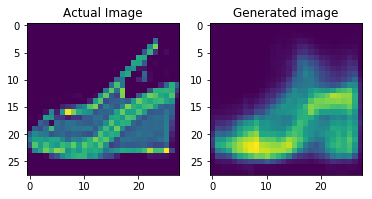

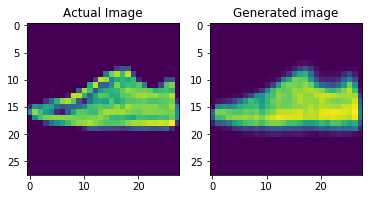

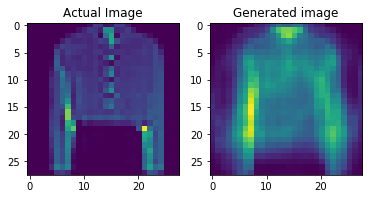

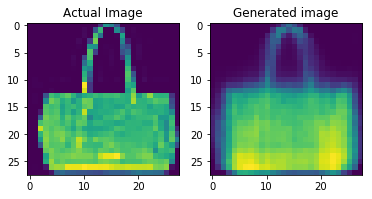

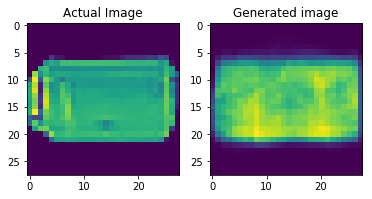

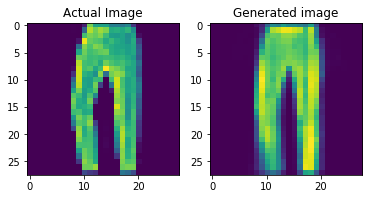

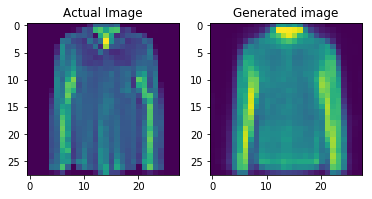

In [13]:
for i, features in enumerate(testing_data):
    features = features.as_in_context(ctx)
    encoded = encode(features)
    decoded = decode(encoded)
    
    plt.subplot(1, 2, 1)
    plt.imshow(features.reshape((28, 28)).asnumpy())
    plt.title('Actual Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(decoded.reshape((28, 28)).asnumpy())
    plt.title('Generated image')
    
    plt.show()
    if i == 9: break

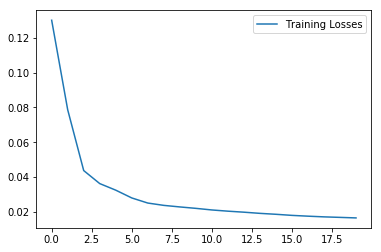

In [14]:
plt.plot(losses, label = 'Training Losses')
plt.legend()
plt.show()